In [1]:
# this notebook is modified from Allen Institute tutorial on working with Meshes
# The original tutorial is located here: https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/intro/MeshExample.ipynb

In [2]:
# you will need to run this notebook in a Python 3.7 environment
# Sometime meshparty will have a conflict with other tools and not work properly in Anaconda
# If that happens, you will need to start over with a new Anaconda environment
# Install allensdk first, then meshparty, then any other other tools desired
# The installation described below worked well:
    # Install new environment v3.7 in Anaconda
    # conda install jupyter
    # pip install allensdk
    # pip install meshparty
    # pip install caveclient
    # pip install 'itkwidgets[notebook]>=1.0a8'
    # pip install --upgrade --pre itk
    # pip install gdown

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [4]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils

In [5]:
# setup the mesh meta to handle downloads and caching
mesh_dir = 'data/'
seg_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v185/seg"
mm = trimesh_io.MeshMeta(cv_path=seg_source,
                         disk_cache_path=mesh_dir, 
                         cache_size=20)

In [6]:
pre_synID = 648518346349539215 # most number of axonal synapses in volume for pre-syn cellid n=1475 (inhibitory Basket neuron)
post_synID = 648518346349538440 # most number of synapses in volume for post-syn cellid n=5369 (excitatory Pyramidal neuron)

In [7]:
# Read mesh off disk
seg_id = post_synID
mesh_file = os.path.join(mesh_dir, str(seg_id)+'.h5')
mesh = mm.mesh(filename = mesh_file)

In [8]:
seg_id

648518346349538440

In [9]:
mesh_file

'data/648518346349538440.h5'

In [10]:
mesh.n_vertices, mesh.n_faces

(2382975, 4765746)

In [11]:
# If you don't have the mesh file, it can be downloaded via cloudvolume and converted to a Mesh object (an extension of trimesh)
# https://github.com/mikedh/trimesh
# see MeshParty docs https://meshparty.readthedocs.io/en/latest/?badge=latest
second_seg_id = pre_synID
second_mesh = mm.mesh(seg_id = second_seg_id, remove_duplicate_vertices=True)

In [12]:
second_seg_id

648518346349539215

In [13]:
second_mesh.n_vertices

2280732

In [14]:
# read in the full synapse table
soma_subgraph_df = pd.read_csv('data/pni_synapses_v185.csv')

In [15]:
soma_subgraph_df.head()

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
0,2715757,648518346349538285,648518346349536759,1103,280784,261896,40600,70050,65534,1015,70196,65474,1015,70104,65602,1015
1,12498,648518346342404863,648518346342414574,62,365832,292808,25800,91472,73196,645,91458,73202,645,91396,73216,645
2,12500,648518346342921567,648518346345323296,62,229144,155952,48080,57250,39028,1202,57286,38988,1202,57312,38966,1203
3,12517,648518346342796822,648518346349537255,955,398452,208560,50760,99538,52184,1276,99613,52140,1269,99550,52098,1276
4,12503,648518346342800412,648518346348190542,718,461868,245212,53560,115462,61350,1335,115467,61303,1339,115468,61296,1335


In [16]:
# this cell and the next one will show all synapses on the seg_id (presynaptic) cell and color code them by post-synaptic sites (red)
# and pre-synaptic sites (green); the latter will predominately be on the axon (efferent) 
# filter the synapses onto this cell
cell_post_subgraph = soma_subgraph_df.query(f'post_root_id=={seg_id}') #this shows all post-syn sites on seg_id cell
cell_pre_subgraph = soma_subgraph_df.query(f'pre_root_id=={seg_id}') #this one shows all pre-syn sites on the axon of seg_id cell

# make an array of xyz synapse positions
postsyn_xyz=cell_post_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values
presyn_xyz=cell_pre_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

(306672.0, 144577.890625)

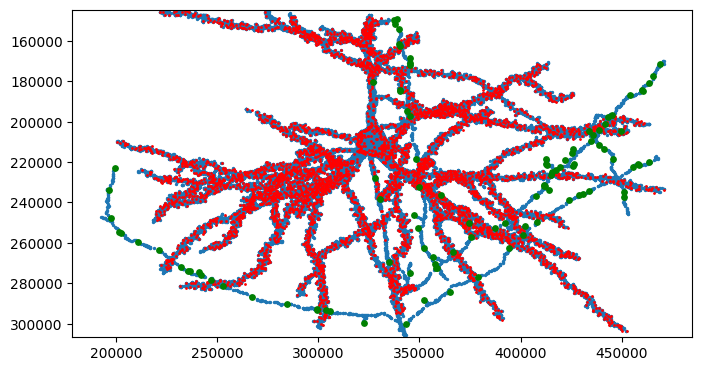

In [17]:
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], s=2, alpha=1) # modify s and alpha to improve the visualization
# add in the locations of synapses between cell bodies

ax.scatter(postsyn_xyz[:,0], postsyn_xyz[:,1], c='red', s=1, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

ax.scatter(presyn_xyz[:,0], presyn_xyz[:,1], c='green', s=15, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

In [18]:
len(postsyn_xyz)

5369

In [19]:
len(presyn_xyz)

106

In [20]:
# this field will create a df that only reveals the second_seg_id (pre) synapses onto the seg_id (post) neuron
pre_to_post_only = soma_subgraph_df["pre_root_id"] == second_seg_id

In [21]:
pre_to_post_only_df=soma_subgraph_df.loc[pre_to_post_only, ["id", "pre_root_id", "post_root_id", "cleft_vx", "ctr_pt_x_nm", "ctr_pt_y_nm", "ctr_pt_z_nm", "pre_pos_x_vx", "pre_pos_y_vx", "pre_pos_z_vx", "ctr_pos_x_vx", "ctr_pos_y_vx", "ctr_pos_z_vx", "post_pos_x_vx", "post_pos_y_vx", "post_pos_z_vx"]]

In [22]:
pre_to_post_only_df # this lists all of the second_seg_id (pre) synapses

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
10588,1600812,648518346349539215,648518346349537649,243,438296,277464,3720,109580,69282,95,109574,69366,93,109516,69342,95
32022,1047036,648518346349539215,648518346349537687,887,404988,157180,68400,101224,39444,1709,101247,39295,1710,101122,39426,1709
32023,2478455,648518346349539215,648518346349537687,635,393760,170160,74440,98366,42528,1866,98440,42540,1861,98466,42506,1866
32039,517090,648518346349539215,648518346349537687,106,359768,200320,12520,89950,50020,312,89942,50080,313,89886,50078,312
34953,2437346,648518346349539215,648518346349538746,597,354808,299056,80800,88696,74818,2016,88702,74764,2020,88656,74726,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215466,1027398,648518346349539215,648518346349538209,159,264168,211952,60640,65996,52956,1517,66042,52988,1516,66050,53034,1517
3220206,2228186,648518346349539215,648518346349531742,441,381536,199680,79280,95310,49898,1983,95384,49920,1982,95406,49874,1983
3220560,1473317,648518346349539215,648518346349538793,221,367944,183168,26000,91932,45842,650,91986,45792,650,91918,45754,651
3225227,999623,648518346349539215,648518346349538730,155,260800,209024,25560,65242,52226,637,65200,52256,639,65160,52250,636


In [23]:
# the following cell should now filter it so that we only reveal the synapses of second_seg_id (pre) onto seg_id (post)
# this assumes there are synaptic connections between the two!

In [24]:
# this cell and the next will reveal the second_seg_id synapses (pre) onto the seg_id (post) cell
# if there are none, an error will be returned
cell_post_subgraph = pre_to_post_only_df.query(f'post_root_id=={seg_id}')

# make an array of xyz synapse positions
postsyn_xyz=cell_post_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

In [25]:
len(pre_to_post_only_df.query(f'post_root_id=={seg_id}'))

8

(306672.0, 144577.890625)

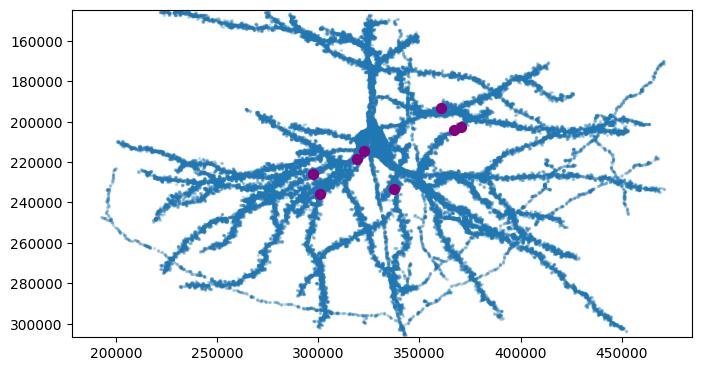

In [26]:
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], s=2, alpha=0.2) # modify s and alpha to improve the visualization
# add in the locations of synapses between cell bodies

ax.scatter(postsyn_xyz[:,0], postsyn_xyz[:,1], c='purple', s=50, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

In [27]:
# 3D visualization
# your computer will need OpenGL installed in order for this tool to work
# It will open in a separate window

In [28]:
import vtk

#create vtk actors for each mesh and one for their shared synapses
mesh_actor = trimesh_vtk.mesh_actor(mesh, opacity=.3, color=(0.7, 0.7, 0.7))
pre_mesh_actor = trimesh_vtk.mesh_actor(second_mesh, opacity=.3, color=(0.2, 0.4, 0.7))
#syn_actor = trimesh_vtk.point_cloud_actor(syn_xyz, size=1000, color=(0.9, 0.2, 0.2)) needed to change this to "postsyn" since I changed that variable name above
syn_actor = trimesh_vtk.point_cloud_actor(postsyn_xyz, size=1000, color=(0.9, 0.2, 0.2)) 


#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(mesh.centroid, backoff=400)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors([mesh_actor,syn_actor,pre_mesh_actor], camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x0000022A132EAE90) at 0x0000022A3AD45408>

In [29]:
# In the following cells, the cellids are reversed

In [30]:
pre_synID =  648518346349538440 # most number of synapses in volume for post-syn cellid n=106 excitatory 
post_synID = 648518346349539215 # most number of synapses in volume for pre-syn cellid n=1475 inhibitory

In [31]:
# Read mesh off disk
seg_id = post_synID
mesh_file = os.path.join(mesh_dir, str(seg_id)+'.h5')
mesh = mm.mesh(filename = mesh_file)

In [32]:
mesh.n_vertices, mesh.n_faces

(2280732, 4559892)

In [33]:
# If you don't have the mesh file, it can be downloaded via cloudvolume and converted to a Mesh object (an extension of trimesh)
# https://github.com/mikedh/trimesh
# see MeshParty docs https://meshparty.readthedocs.io/en/latest/?badge=latest
second_seg_id = pre_synID
second_mesh = mm.mesh(seg_id = second_seg_id, remove_duplicate_vertices=True)

In [34]:
second_mesh.n_vertices

2382975

In [35]:
# this cell and the next one will show all synapses on the seg_id (presynaptic) cell and color code them by post-synaptic sites (red)
# and pre-synaptic sites (green); the latter will predominately be on the axon (efferent) 
# filter the synapses onto this cell
cell_post_subgraph = soma_subgraph_df.query(f'post_root_id=={seg_id}') #this shows all post-syn sites on seg_id cell
cell_pre_subgraph = soma_subgraph_df.query(f'pre_root_id=={seg_id}') #this one shows all pre-syn sites on the axon of seg_id cell

# make an array of xyz synapse positions
postsyn_xyz=cell_post_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values
presyn_xyz=cell_pre_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

(312242.34375, 148041.234375)

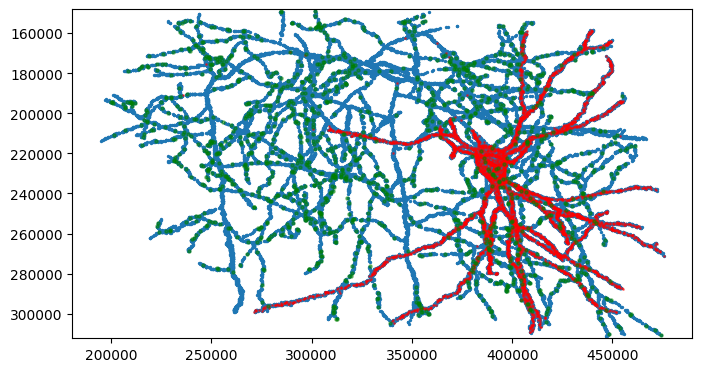

In [36]:
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], s=2, alpha=1) # modify s and alpha to improve the visualization
# add in the locations of synapses between cell bodies

ax.scatter(postsyn_xyz[:,0], postsyn_xyz[:,1], c='red', s=1, alpha=0.5) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

ax.scatter(presyn_xyz[:,0], presyn_xyz[:,1], c='green', s=5, alpha=0.5) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

In [37]:
len(postsyn_xyz)

4891

In [38]:
len(presyn_xyz)

1475

In [39]:
# this field will create a df that only reveals the second_seg_id (pre) synapses onto the seg_id (post) neuron
pre_to_post_only = soma_subgraph_df["pre_root_id"] == second_seg_id

In [40]:
pre_to_post_only_df=soma_subgraph_df.loc[pre_to_post_only, ["id", "pre_root_id", "post_root_id", "cleft_vx", "ctr_pt_x_nm", "ctr_pt_y_nm", "ctr_pt_z_nm", "pre_pos_x_vx", "pre_pos_y_vx", "pre_pos_z_vx", "ctr_pos_x_vx", "ctr_pos_y_vx", "ctr_pos_z_vx", "post_pos_x_vx", "post_pos_y_vx", "post_pos_z_vx"]]

In [41]:
pre_to_post_only_df # this lists all of the second_seg_id (pre) synapses

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
43385,3362441,648518346349538440,648518346349533227,93,412616,220784,80360,103128,55178,2010,103154,55196,2009,103174,55202,2008
77607,585587,648518346349538440,648518346349533719,112,445976,218688,22440,111468,54626,561,111494,54672,561,111512,54686,562
87444,741207,648518346349538440,648518346349532796,128,412896,221336,76920,103258,55358,1925,103224,55334,1923,103200,55308,1925
98677,7163,648518346349538440,648518346349517783,62,352248,262368,60440,88004,65592,1510,88062,65592,1511,88106,65582,1510
108599,2356651,648518346349538440,648518346349537153,523,408096,249616,53000,101964,62378,1321,102024,62404,1325,102054,62402,1321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125154,2274529,648518346349538440,648518346349528994,468,394216,262720,57840,98564,65648,1446,98554,65680,1446,98474,65664,1446
3125157,3099379,648518346349538440,648518346349537404,60,374300,250268,74880,93578,62548,1872,93575,62567,1872,93656,62570,1871
3125158,2384556,648518346349538440,648518346349537583,547,423872,238624,55160,105982,59698,1379,105968,59656,1379,105922,59650,1379
3125161,305572,648518346349538440,648518346349539863,57,328248,227888,59160,82020,56974,1480,82062,56972,1479,82082,56966,1480


In [42]:
# this cell and the next will reveal the second_seg_id synapses (pre) onto the seg_id (post) cell
# if there are none, the display will not have any dots to indicate the synapses (since it is zero)
cell_post_subgraph = pre_to_post_only_df.query(f'post_root_id=={seg_id}')

# make an array of xyz synapse positions
postsyn_xyz=cell_post_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

In [43]:
len(pre_to_post_only_df.query(f'post_root_id=={seg_id}'))

0

(312242.34375, 148041.234375)

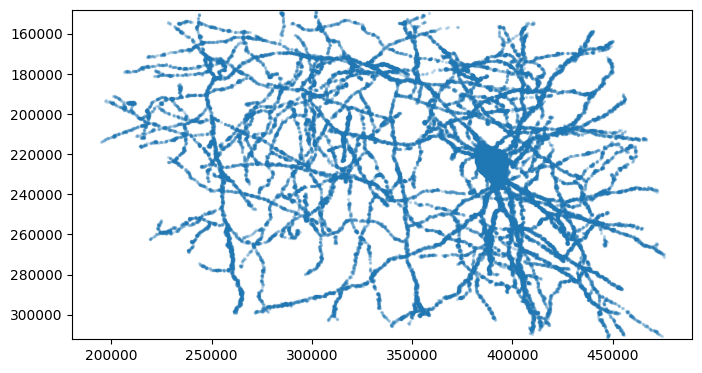

In [44]:
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], s=2, alpha=0.2) # modify s and alpha to improve the visualization
# add in the locations of synapses between cell bodies

ax.scatter(postsyn_xyz[:,0], postsyn_xyz[:,1], c='purple', s=50, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

In [45]:
import vtk

#create vtk actors for each mesh and one for their shared synapses
mesh_actor = trimesh_vtk.mesh_actor(mesh, opacity=.3, color=(0.7, 0.7, 0.7))
pre_mesh_actor = trimesh_vtk.mesh_actor(second_mesh, opacity=.3, color=(0.2, 0.4, 0.7))
#syn_actor = trimesh_vtk.point_cloud_actor(syn_xyz, size=1000, color=(0.9, 0.2, 0.2)) needed to change this to "postsyn" since I changed that variable name above
syn_actor = trimesh_vtk.point_cloud_actor(postsyn_xyz, size=1000, color=(0.9, 0.2, 0.2)) 


#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(mesh.centroid, backoff=400)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors([mesh_actor,syn_actor,pre_mesh_actor], camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x0000022A1A178080) at 0x0000022A3AD8C2E8>